# Analysis

## Baseline betting

In [12]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/')

In [69]:
result = pd.read_csv('result_collection/match_corner_result.csv')
result

,event_id,game_starting_time,league,home,away,result_corner
0,20200213THU7,14/2/2020 06:15,NaN,Zamora FC,Plaza Colonia,9
1,20200214FRI1,14/2/2020 16:30,NaN,Adelaide Utd,Central Coast Mariners,17
2,20200214FRI29,15/2/2020 08:10,NaN,Colon,Racing Club,10
3,20200215SAT3,15/2/2020 20:00,NaN,Mallorca,Alaves,13
4,20200215SAT48,16/2/2020 01:30,NaN,Norwich,Liverpool,9
5,20200215SAT60,16/2/2020 03:45,NaN,Atalanta,Roma,7
6,20200216SUN37,17/2/2020 00:30,NaN,Arsenal,Newcastle,11
7,20200216SUN50,17/2/2020 06:40,NaN,Lanus,Newell's Old Boys,9


In [67]:
df = {}
lines = {}
for event_id in result.event_id:
    df[event_id] = pd.read_csv('data_collection/data/'+event_id+'.csv')
    df[event_id] = df[event_id][df[event_id].chl_line != "---"]
    df[event_id] = df[event_id].merge(result[result.event_id == event_id][['event_id','result_corner']], 
                                      how = 'outer', on = 'event_id')
    df[event_id]['chl_hi_prob'] = 1/df[event_id]['chl_hi'].astype(float)
    df[event_id]['chl_low_prob'] = 1/df[event_id]['chl_low'].astype(float)
    df[event_id]['bet_decision'] = np.where(df[event_id]['chl_hi_prob'] > df[event_id]['chl_low_prob'], 
                                        'chl_hi', 'chl_low')
    df[event_id]['winning_decision'] = np.where(df[event_id]['result_corner'] > df[event_id]['chl_line'], 
                                     'chl_hi', 'chl_low')
    df[event_id]['is_winning'] = np.where(df[event_id]['bet_decision']==df[event_id]['winning_decision'],1, 0)

    print(df[event_id][['minutes','is_winning']].groupby('is_winning').count())

            minutes
is_winning         
0               523
1               602
            minutes
is_winning         
0                39
1               213
            minutes
is_winning         
0               293
1               729
            minutes
is_winning         
0               259
1               694


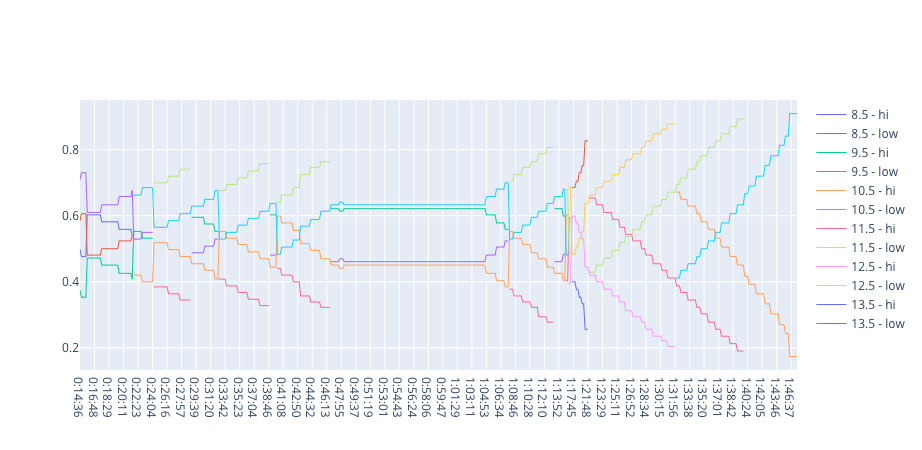

In [29]:
data = df[result.event_id[7]]

time_list = sorted(list(set(data.minutes)))
lines = list(set(data.chl_line))
data_dict = {}
time_range = [data.minutes.min(axis=0), data.minutes.max(axis=0)]
for line in lines:
    filtered_data = data[data.chl_line==line][['minutes', 'chl_hi', 'chl_low']].sort_values(by=['minutes'])
    data_dict[line] = pd.DataFrame({'minutes': time_list})
    data_dict[line] = data_dict[line].merge(filtered_data, 
                                            how='outer', on='minutes')
def gen_separate_dict(data_dict, lines):
    feed_dict = {}
    for line in lines:
        feed_dict[line] = {'x':data_dict[line].minutes, 
                           'y':data_dict[line].chl_hi, 
                           'type':'lines+markers', 
                           'name':'{} - hi'.format(line)}
    return feed_dict

feed_dict = gen_separate_dict(data_dict,lines)

layout = go.Layout(
        xaxis=dict(
            range=time_range
        ),
    )

fig = go.Figure()
for line in lines:
    for hilow in ['hi', 'low']:
        fig.add_trace(go.Scatter(x=data_dict[line]['minutes'], 
                                 y=1/data_dict[line]['chl_{}'.format(hilow)], 
                                 mode='lines', 
                                 name='{} - {}'.format(line, hilow), 
                                 line=dict(width=1), 
                                 marker=dict(size=2)))
fig.show()

---

## Analysis 2

### Traditional statistical inference

In [46]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/')
# one example
df = pd.read_csv('data_collection/data/20200218TUE20.csv')
# remvoe NaN and ---
df = df[(~df.total_corner.isna()) & (df.total_corner!="---")]
df = df[(~df.chl_line.isna()) & (df.chl_line!="---")]
df = df[(~df.chl_hi.isna()) & (df.chl_hi!="---")]
df = df[(~df.chl_low.isna()) & (df.chl_low!="---")]
df = df.reset_index(drop = True)
df['hour'] = df.minutes.apply(lambda x: int(x.split(':')[0]))
df['minute'] = df.minutes.apply(lambda x: int(x.split(':')[1]))
df['time'] = df.minute+60*df.hour
print(df.tail())

          event_id            timestamp  minutes total_corner home_score  \
927  20200218TUE20  2020-02-19 12:36:56  1:36:56            9          1   
928  20200218TUE20  2020-02-19 12:37:07  1:37:07            9          1   
929  20200218TUE20  2020-02-19 12:37:07  1:37:07            9          1   
930  20200218TUE20  2020-02-19 12:37:17  1:37:17            9          1   
931  20200218TUE20  2020-02-19 12:37:17  1:37:17            9          1   

    away_score  chl_line  chl_hi  chl_low  hour  minute  time  
927          0      12.5    4.10     1.19     1      36    96  
928          0      11.5    2.25     1.57     1      37    97  
929          0      12.5    4.10     1.19     1      37    97  
930          0      11.5    2.25     1.57     1      37    97  
931          0      12.5    4.10     1.19     1      37    97  


In [19]:
lines = list(set(df.chl_line))
data = {}
for line in lines:
    print(line)
    data[line] = df[df.chl_line == line]

8.5
9.5
10.5
11.5
12.5


In [47]:
# assume the poisson distribution
# calculate the lambda per game parameter at any moment
# lambda according to bookmaker's sentiment (the lines offered at that time)
param_df = df[['minutes', 'chl_line']].groupby('minutes').mean()
param_df
param_df.head()

,chl_line
minutes,
0:06:36,10.5
0:06:46,9.5
0:06:56,9.5
0:07:07,9.5
0:07:17,10.0


In [31]:
from datetime import timedelta
# length of game (max of minutes minus half time assuming 15 mins)
# alternatively, assume 90 minutes (assuming 0 overtime)
max(df.minutes) - timedelta(minutes=12)
game_length = 90 # minutes

In [49]:
df = df.merge(param_df, how='outer', on='minutes')
df

,event_id,timestamp,minutes,total_corner,home_score,away_score,chl_line_x,chl_hi,chl_low,hour,minute,time,chl_line_y,chl_line
0,20200218TUE20,2020-02-19 11:06:36,0:06:36,0,0,0,10.5,2.05,1.68,0,6,6,10.5,10.5
1,20200218TUE20,2020-02-19 11:06:46,0:06:46,0,0,0,9.5,1.67,2.07,0,6,6,9.5,9.5
2,20200218TUE20,2020-02-19 11:06:56,0:06:56,0,0,0,9.5,1.67,2.07,0,6,6,9.5,9.5
3,20200218TUE20,2020-02-19 11:07:07,0:07:07,0,0,0,9.5,1.67,2.07,0,7,7,9.5,9.5
4,20200218TUE20,2020-02-19 11:07:17,0:07:17,0,0,0,9.5,1.68,2.05,0,7,7,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,20200218TUE20,2020-02-19 12:36:56,1:36:56,9,1,0,12.5,4.10,1.19,1,36,96,12.0,12.0
928,20200218TUE20,2020-02-19 12:37:07,1:37:07,9,1,0,11.5,2.25,1.57,1,37,97,12.0,12.0
929,20200218TUE20,2020-02-19 12:37:07,1:37:07,9,1,0,12.5,4.10,1.19,1,37,97,12.0,12.0
930,20200218TUE20,2020-02-19 12:37:17,1:37:17,9,1,0,11.5,2.25,1.57,1,37,97,12.0,12.0


In [80]:
import os
import pandas as pd

os.chdir('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/data_collection/')
data_path = 'data/20200219WED3.csv'
data = pd.read_csv(data_path)

# remove rows with --- ie. suspensions of bets
data = data[(data.chl_line != "---")]
data = data[(~data.chl_line.isna())]
print(data[data.total_corner == "---"])

# split data to data_dict by line
lines = list(set(data.chl_line))
data_dict = {}
time_list = sorted(list(set(data.minutes)))
print(lines)

for line in lines:
    filtered_data = data[data.chl_line==line][['minutes', 'chl_line', 'chl_hi', 'chl_low']].sort_values(
        by=['minutes'])
    data_dict[line] = pd.DataFrame({'minutes': time_list})
    data_dict[line] = data_dict[line].merge(filtered_data,
                                            how='outer', on='minutes')
    data_dict[line]['minutes'] = data_dict[line]['minutes'].apply(
        lambda x: datetime.strptime(str('20200219'+x), "%Y%m%d%H:%M:%S")) # convert to date

feed_list_hi = []
feed_list_low = []
for line in lines:
    feed_list_hi.append({'x':data_dict[line]['minutes'],
                         'y':data_dict[line]['chl_hi'],
                         'mode':'lines',
                         'name':'{} - hi'.format(line)})
    feed_list_low.append({'x':data_dict[line]['minutes'],
                          'y':data_dict[line]['chl_low'],
                          'mode':'lines',
                          'name':'{} - low'.format(line)})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print([df['y'] for df in feed_list_hi])
#     print([1/df['y'] for df in feed_list_low])

# data for # total corner
total_corner = data[['minutes','total_corner']]
total_corner = total_corner[(total_corner.total_corner != "---") & (total_corner.total_corner != "")]

total_corner['minutes'] = total_corner['minutes'].apply(
        lambda x: datetime.strptime(str('20200219'+x), "%Y%m%d%H:%M:%S")) # convert to date
total_corner = total_corner.drop_duplicates(keep='first')

Empty DataFrame
Columns: [event_id, timestamp, minutes, total_corner, home_score, away_score, chl_line, chl_hi, chl_low]
Index: []
['10.5', '9.5', '12.5', '13.5', '11.5', '7.5', '8.5']
[0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
30      NaN
31      NaN
32      NaN
33      NaN
34      NaN
35      NaN
36      NaN
37      NaN
38      NaN
39      NaN
40      NaN
41      NaN
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47      NaN
48      NaN
49      NaN
50      NaN
51      NaN
52      NaN
53      NaN
54      NaN
55      NaN
56      NaN
57      NaN
58      NaN
59      NaN
60      NaN
61      NaN
62      NaN
63      NaN
64      NaN
65      NaN
66      NaN
67      Na